In [4]:
import sys
sys.path.append("./tools")

In [2]:
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit import execute, Aer

simulator = Aer.get_backend('qasm_simulator')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
palette = {
    'unitary': '#FF9966', 'vqc': '#66CC99', 
}

In [6]:
%matplotlib inline

In [7]:
%%html
<style>
table {float:left;}
</style>

## Tool Modules

In [8]:
from quantum import *
from measurements import *

from unitary import *
from VQC import *

from dataSL import *
from QOLearner import *

from noise import *
from lipschitz import *

## Prepare Circuits

### - Input Circuits

In [9]:
def initCircuit(n):
    circuit = QuantumCircuit(2 * n, 2 * n)
    senders = circuit.qubits[0:n]
    receivers = circuit.qubits[n:]
    
    for sender, receiver in zip(senders, receivers):
        circuit.h(sender)
        circuit.cx(sender, receiver)
        
    return senders, receivers, circuit

In [10]:
def operate(circuit, target, bits):
    """
        => Z^(b_1) * X^(b_2)
    """
    if bits[0] == '1':
        circuit.z(target)
    if bits[1] == '1':
        circuit.x(target)

    return circuit

def getCircuit(n, classical_bits):
    bits_str = ''.join(classical_bits)
    """
        getCircuit(circuit, ["01", "10", "00"])
            => X(A1), Z(A2), I(A3)
    """
    senders, receivers, circuit = initCircuit(n)
    circuit_copy = circuit.copy()
    
    circuit_copy.barrier(senders)
    for i, sender in enumerate(senders):
        operate(circuit_copy, sender, classical_bits[i])

    return circuit_copy

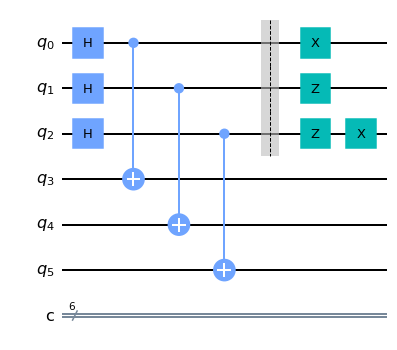

In [11]:
qc = getCircuit(3, ["01", "10", "11"])
qc.draw(output='mpl')

In [12]:
inputCircuits = []
n = 3

classical_bits = ["00", "01", "10", "11"]
for comb in combs[n]:
    inputCircuits.append( getCircuit(n, list(map( lambda x: classical_bits[int(x)] , list(comb)))) )

print(len(inputCircuits)) # 64

64


### - Output Circuits

In [13]:
def getMeasureCircuit(n):
    circuit = QuantumCircuit(2 * n, 2 * n)
    
    for i in range(n):
        circuit.cx(i, i + n)
        circuit.h(i)
    
    return circuit

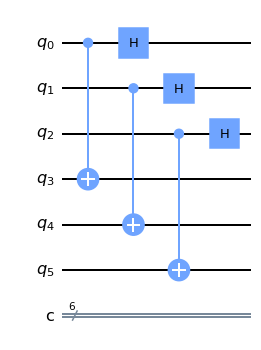

In [14]:
n = 3

measureCircuit = getMeasureCircuit(n)
measureCircuit.draw(output='mpl')

## Train paramters

In [15]:
import time
import sys
stdout = sys.stdout

In [16]:
# experiments times
MAX_TIMES = 10

### - expecetd

In [17]:
expected = {}

n = 3
for i in range(2 ** (2 * n)):
    expected[bin(i)[2:].rjust(2 * n, '0')] = 1

print(expected)
print(len(expected)) # 4 ** n

{'000000': 1, '000001': 1, '000010': 1, '000011': 1, '000100': 1, '000101': 1, '000110': 1, '000111': 1, '001000': 1, '001001': 1, '001010': 1, '001011': 1, '001100': 1, '001101': 1, '001110': 1, '001111': 1, '010000': 1, '010001': 1, '010010': 1, '010011': 1, '010100': 1, '010101': 1, '010110': 1, '010111': 1, '011000': 1, '011001': 1, '011010': 1, '011011': 1, '011100': 1, '011101': 1, '011110': 1, '011111': 1, '100000': 1, '100001': 1, '100010': 1, '100011': 1, '100100': 1, '100101': 1, '100110': 1, '100111': 1, '101000': 1, '101001': 1, '101010': 1, '101011': 1, '101100': 1, '101101': 1, '101110': 1, '101111': 1, '110000': 1, '110001': 1, '110010': 1, '110011': 1, '110100': 1, '110101': 1, '110110': 1, '110111': 1, '111000': 1, '111001': 1, '111010': 1, '111011': 1, '111100': 1, '111101': 1, '111110': 1, '111111': 1}
64


## Strategy: unitary

In [18]:
qol_unitary = QOLearnerBase([inputCircuits, measureCircuit], 3, [0, 1, 2], expected)

In [ ]:
times_unitary_early = []

for i in range(MAX_TIMES):
    sys.stdout = None
    start = time.clock()
    qol_unitary.fit(epoch=1000, strategy='unitary', stepsize=0.005, early_stopping=True)
    end = time.clock()
    times_unitary_early.append(end - start)
    sys.stdout = stdout
    print(f'Fin - No. {i + 1}')
    
    saveParams(qol_unitary.params[-1], 'sdc3', 'unitary', i + 1)
    saveLosses(qol_unitary.losses, 'sdc3', 'unitary', i + 1)

In [20]:
# 10598.685
# print(f'Average times for unitary-early: {np.mean(times_unitary_early)}')

### - plot a loss example

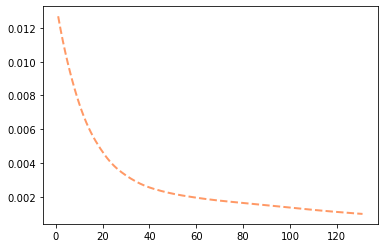

In [21]:
plot(loadLosses('sdc3', 'unitary', 8), color=palette['unitary'])

In [22]:
losses_unitary_early = []
max_length = 0
for i in range(MAX_TIMES):
    losses_unitary_early.append(loadLosses('sdc3', 'unitary', i + 1))
    max_length = max(max_length, len(losses_unitary_early[-1]))

for i in range(MAX_TIMES):
    length = len(losses_unitary_early[i])
    while length < max_length:
        losses_unitary_early[i].append(losses_unitary_early[i][-1])
        length += 1

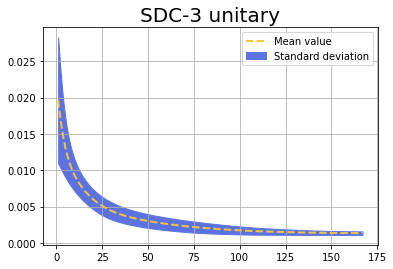

In [53]:
plotLosses(losses_unitary_early, color="#F5C340", fill_color="#5B72E0", title='SDC-3 unitary')

### - average time and loss

In [55]:
average_loss_unitary = 0.0
for i in range(MAX_TIMES):
    loss = loadLosses('sdc3', 'unitary', i + 1)[-1]
    average_loss_unitary += loss
print(f'Average loss for unitary: {average_loss_unitary / MAX_TIMES}')

Average loss for unitary: (0.0013471773823631513+0j)


In [56]:
average_epoch_unitary = 0
for i in range(MAX_TIMES):
    loss = loadLosses('sdc3', 'unitary', i + 1)
    average_epoch_unitary += len(loss)
print(f'Average epoch for unitary: {average_epoch_unitary / MAX_TIMES}')

Average epoch for unitary: 126.0


In [57]:
average_time_unitary = 10598.685

In [58]:
average_time_per_epoch_unitary = average_time_unitary / average_epoch_unitary
print(f'Average time per epoch for unitary: {average_time_per_epoch_unitary}')

Average time per epoch for unitary: 8.411654761904762


|Strategy| parameterized unitary |
|:----------------:|:-----:|
| Average loss | 1.347e-3 |
| Average time | 10598.7 |
| Average epochs | 126.0 |
| Average time per epoch | 8.412 |

## Strategy: VQC

In [24]:
qol_vqc = QOLearnerBase([inputCircuits, measureCircuit], 3, [0, 1, 2], expected)

In [45]:
times_vqc_early = []

for i in range(7, 14):
    sys.stdout = None
    start = time.clock()
    qol_vqc.fit(epoch=1000, strategy='vqc', stepsize=0.005, early_stopping=True)
    end = time.clock()
    times_vqc_early.append(end - start)
    sys.stdout = stdout
    print(f'Fin - No. {i + 1}')
    
    saveParams(qol_vqc.params[-1], 'sdc3', 'vqc', i + 1)
    saveLosses(qol_vqc.losses, 'sdc3', 'vqc', i + 1)

Fin - No. 8
Fin - No. 9
Fin - No. 10
Fin - No. 11
Fin - No. 12
Fin - No. 13
Fin - No. 14


In [26]:
# 4839.122767319997

In [26]:
print(f'Average times for vqc-early: {np.mean(times_vqc_early)}')

Average times for vqc-early: 4839.122767319997


### - plot a loss example

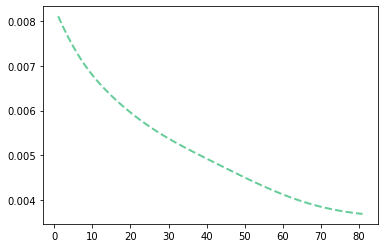

In [46]:
plot(loadLosses('sdc3', 'vqc', 5), color=palette['vqc'])

In [19]:
losses_vqc_early = []
max_length = 0
for i in range(10):
    losses_vqc_early.append(loadLosses('sdc2', 'vqc', i + 1))
    max_length = max(max_length, len(losses_vqc_early[-1]))

for i in range(10):
    length = len(losses_vqc_early[i])
    while length < max_length:
        losses_vqc_early[i].append(losses_vqc_early[i][-1])
        length += 1

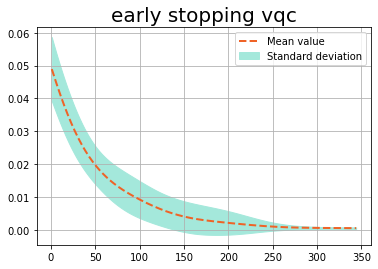

In [54]:
plotLosses(losses_vqc_early, color="#EF6327", fill_color="#A4E8DB", title="early stopping vqc")

### - average time and loss

In [60]:
average_loss_vqc = 0.0
for i in range(MAX_TIMES):
    loss = loadLosses('sdc3', 'vqc', i + 1)[-1]
    average_loss_vqc += loss
print(f'Average loss for vqc: {average_loss_vqc / MAX_TIMES}')

Average loss for vqc: (0.0005458991404556508+0j)


In [61]:
average_epoch_vqc = 0
for i in range(MAX_TIMES):
    loss = loadLosses('sdc3', 'vqc', i + 1)
    average_epoch_vqc += len(loss)
print(f'Average epoch for vqc: {average_epoch_vqc / MAX_TIMES}')

Average epoch for vqc: 159.4


In [62]:
average_time_vqc = 4839.122767319997

In [63]:
average_time_per_epoch_vqc = average_time_vqc / average_epoch_vqc
print(f'Average time per epoch for vqc: {average_time_per_epoch_vqc}')

Average time per epoch for vqc: 3.035836115006272


| Strategy | VQC |
|:----------------:|:-----:|
| Average loss | 5.459e-4 |
| Average time | 4839.12 |
| Average epochs | 159.4 |
| Average time per epoch | 3.0358 |

##  Summarize

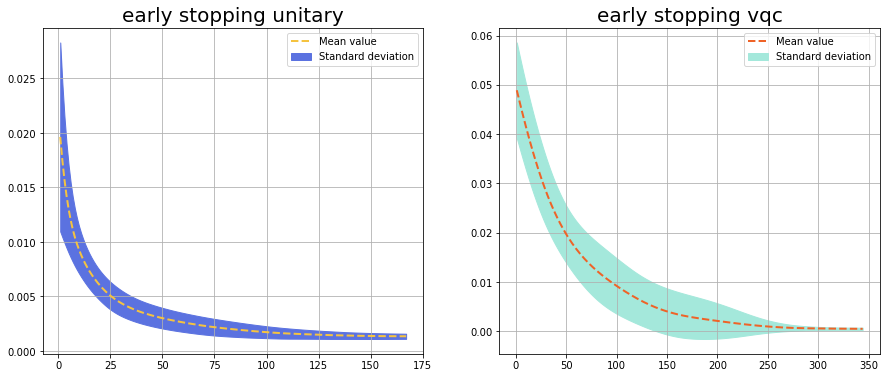

In [29]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plotLosses(losses_unitary_early, color="#F5C340", fill_color="#5B72E0", title="early stopping unitary")
plt.subplot(1,2,2)
plotLosses(losses_vqc_early, color="#EF6327", fill_color="#A4E8DB", title="early stopping vqc")

|Indicators| PUG | VQC |
|:----------------:|:-----:|:-----:|
| Average loss | 1.347e-3 |5.459e-4 |
| Average time | 10598.7 |4839.12 |
| Average epochs | 126.0 |159.4 |
| Average time per epoch | 8.412 |3.0358 |
| Total parameters | 64 |18 |

## Compare Lipschitz

In [20]:
measurements = getMeasurements(6)

In [21]:
names = ['unitary', 'vqc']

In [22]:
error_params = [
    [0.0001 , 'b'], [0.0001 , 'p'], [0.0001 , 'd'], 
    [0.001 , 'b'], [0.001 , 'p'], [0.001 , 'd'], 
    [0.01 , 'b'], [0.01 , 'p'], [0.01 , 'd'],
    [0.1 , 'b'], [0.1 , 'p'], [0.1 , 'd'], 
]

### - exact Lipschitz

In [23]:
smallestDict = { k: 0 for k in names }

for (p, errorType) in error_params:
    print(f' - p = {p}, errorType: {errorType}')
    
    # simulate noise input circuits
    noiseInputCircuits = getNoiseCircuits(inputCircuits, p, errorType)

    smallest = 1.0; smallestKey = ''
    for name in names: # unitary or vqc
        lip = 0.0
        
        for i in range(MAX_TIMES):
            # build targetCircuit
            params = loadParams('sdc3', name, i + 1)
            targetCircuit = QuantumCircuit(6, 6)
            
            if name == 'unitary':
                targetCircuit.append(buildU(3, params), [0, 1, 2])
            else:
                targetCircuit = getVQCCircuit(targetCircuit, 3, params, [0, 1, 2])
                
            lip += calculateExactLipschitz2(
                inputCircuits, noiseInputCircuits, 
                targetCircuit, measureCircuit, measurements
            )
        lip = lip / MAX_TIMES
        
        if lip < smallest:
            smallest = lip
            smallestKey = name
        
        print(f'Lipschitz for [{name}] is: {lip}\n')
    
    smallestDict[smallestKey]  += 1.0
    print(f'smallest one: [{smallestKey}]')
        
    print('-' * 25)
    print()

print(smallestDict)

 - p = 0.0001, errorType: b
Lipschitz for [unitary] is: 0.003162687422573131

Lipschitz for [vqc] is: 0.0014377140620858192

smallest one: [vqc]
-------------------------

 - p = 0.0001, errorType: p
Lipschitz for [unitary] is: 0.003164588006628636

Lipschitz for [vqc] is: 0.001438285976069647

smallest one: [vqc]
-------------------------

 - p = 0.0001, errorType: d
Lipschitz for [unitary] is: 0.0031639148537089476

Lipschitz for [vqc] is: 0.0014381204557861456

smallest one: [vqc]
-------------------------

 - p = 0.001, errorType: b
Lipschitz for [unitary] is: 0.0031456853306971377

Lipschitz for [vqc] is: 0.0014326713354861733

smallest one: [vqc]
-------------------------

 - p = 0.001, errorType: p
Lipschitz for [unitary] is: 0.0031645880069868446

Lipschitz for [vqc] is: 0.001438285976260405

smallest one: [vqc]
-------------------------

 - p = 0.001, errorType: d
Lipschitz for [unitary] is: 0.0031578671957740744

Lipschitz for [vqc] is: 0.001436631542659711

smallest one: [vq

KeyboardInterrupt: 

<table>
    <tr>
        <th style="text-align: center" rowspan="2">Strategy</th><th style="text-align: center" rowspan="2">Error Type</th><th style="text-align: center" colspan="4">Probability</th>
    </tr>
    <tr>
                                                 <td style="text-align: center">0.0001</td><td style="text-align: center">0.001</td><td style="text-align: center">0.01</td><td style="text-align: center">0.1</td>
    </tr>
    <tr>
        <td style="text-align: center" rowspan="3">PUG</td><td style="text-align: center">bit flip</td><td>3.163e-3</td><td>3.146e-3</td><td>2.539e-3</td><td>2.488e-3</td>
    </tr>
    <tr>
        <td style="text-align: center">phase flip</td><td>3.995e-15</td><td>2.077e-15</td><td>2.594e-16</td><td>3.054e-17</td>
    </tr>
    <tr>
        <td style="text-align: center">depolarizing</td><td>1.329e-3</td><td>1.331e-3</td><td>1.347e-3</td><td>1.506e-3</td>
    </tr>
    <tr>
        <td style="text-align: center" rowspan="3">VQC</td><td style="text-align: center">bit flip</td><td>1.031e-3</td><td>1.031e-3</td><td>1.027e-3</td><td>9.885e-4</td>
    </tr>
    <tr>
        <td style="text-align: center">phase flip</td><td>1.992e-15</td><td>9.779e-16</td><td>1.165e-16</td><td>1.397e-17</td>
    </tr>
    <tr>
        <td style="text-align: center">depolarizing</td><td>5.459e-4</td><td>5.464e-4</td><td>5.519e-4</td><td>6.049e-4</td>
    </tr>
    
</table>

### - approximate Lipschitz

In [66]:
for name in names: # unitary or vqc
    lip = 0.0
    best_index = -1; best_lip = 1

    for i in range(MAX_TIMES):
        # build targetCircuit
        params = loadParams('sdc3', name, i + 1)
        targetCircuit = QuantumCircuit(6, 6)

        if name == 'unitary':
            targetCircuit.append(buildU(3, params), [0, 1, 2])
        else:
            targetCircuit = getVQCCircuit(targetCircuit, 3, params, [0, 1, 2])

        score = calculateLipschitz(targetCircuit, measureCircuit, measurements)
        
        if score < best_lip:
            best_lip = score
            best_index = i + 1
        
        lip += score
                                  
    lip = lip / MAX_TIMES

    print(f'Lipschitz for [{name}] is: {lip}(best params: No.{best_index}({best_lip}))\n')

Lipschitz for [unitary] is: 0.0012314728904562536(best params: No.5(1.884346545544419e-05))

Lipschitz for [vqc] is: 0.0006540311177380494(best params: No.1(5.2778759969748e-11))

